###Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками.
###Обучить случайный лес из 1, 3, 10, 50, 100 и 200 деревьев (за основу взять реализацию построения этого алгоритма из урока).
###Визуализировать их разделяющие линии на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).
###Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.


In [1]:
from sklearn.datasets import make_classification

In [2]:
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_classes=2, n_redundant=0, n_clusters_per_class=2, flip_y=0.1, random_state=7)

In [3]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification

import numpy as np

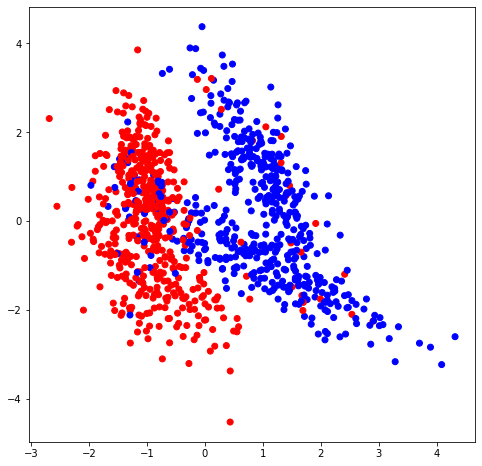

In [4]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(X[:, 0], X[:, 1], 
              c=y, cmap=colors);

Реализуем генерацию $N$ бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.

In [5]:
np.random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [6]:
def get_subsample(len_sample):
    sample_indexes = list(range(len_sample))
    len_subsample = int(np.round(np.sqrt(len_sample)))
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)
    return subsample

In [7]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [8]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction   

In [9]:
#Критерий Джини

def gini(labels):
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [10]:
#Расчет прироста

def gain(left_labels, right_labels, root_gini):
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [11]:
#Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [12]:
#Нахождение наилучшего разбиения

def find_best_split(data, labels):
    root_gini = gini(labels)
    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    feature_subsample_indices = get_subsample(n_features) 
    
    for index in feature_subsample_indices:
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
     
            current_gain = gain(true_labels, false_labels, root_gini)
            
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [13]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):
    gain, t, index = find_best_split(data, labels)
    if gain == 0:
        return Leaf(data, labels)
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    return Node(index, t, true_branch, false_branch)

In [14]:
#Функция формирования случайного леса

def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [15]:
#Функция классификации отдельного объекта

def classify_object(obj, node):

    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [16]:
#Функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [17]:
#Функция предсказания голосованием деревьев

def tree_vote(forest, data):
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    predictions_per_object = list(zip(*predictions))
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [18]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.3, random_state=1)

In [19]:
#Функция подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [20]:
#Функция визуализации графиков обучающей и тестовой выборок
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

def visualize(train_data, test_data):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(my_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'N_trees={i}\nTrain accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'N_trees={i}\nTest accuracy={test_accuracy:.2f}')

### Построим несколько случайных лесов с разным количеством деревьев в них.

Точность случайного леса из 1 деревьев на обучающей выборке: 92.857, на тестовой выборке: 85.333
Точность случайного леса из 3 деревьев на обучающей выборке: 97.571, на тестовой выборке: 85.000
Точность случайного леса из 5 деревьев на обучающей выборке: 97.571, на тестовой выборке: 89.333
Точность случайного леса из 10 деревьев на обучающей выборке: 99.000, на тестовой выборке: 89.000
Точность случайного леса из 50 деревьев на обучающей выборке: 100.000, на тестовой выборке: 91.000
Точность случайного леса из 100 деревьев на обучающей выборке: 100.000, на тестовой выборке: 90.333
Точность случайного леса из 200 деревьев на обучающей выборке: 100.000, на тестовой выборке: 91.000
CPU times: user 3min 46s, sys: 1.42 s, total: 3min 48s
Wall time: 3min 56s


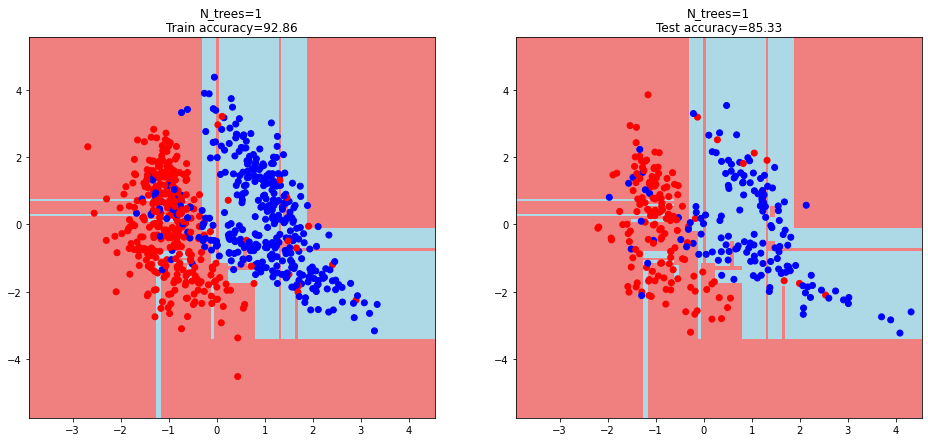

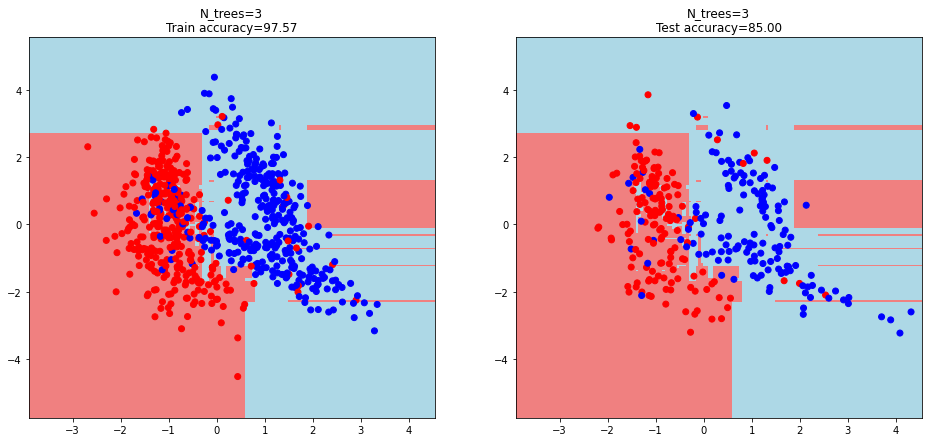

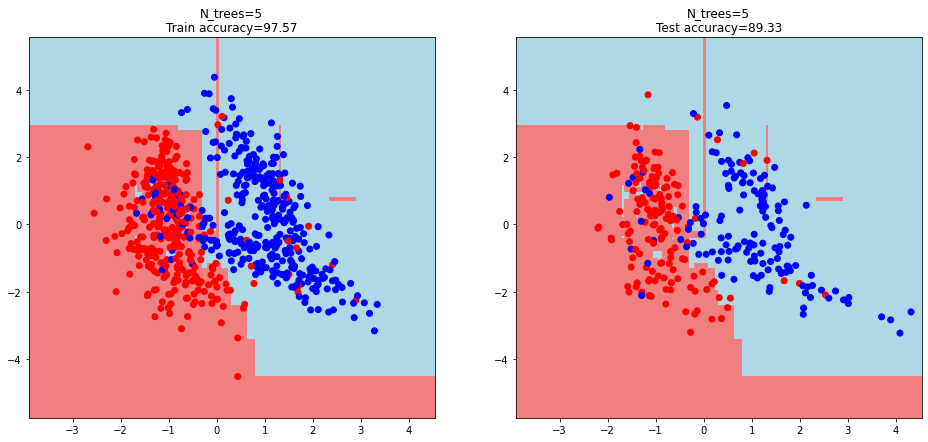

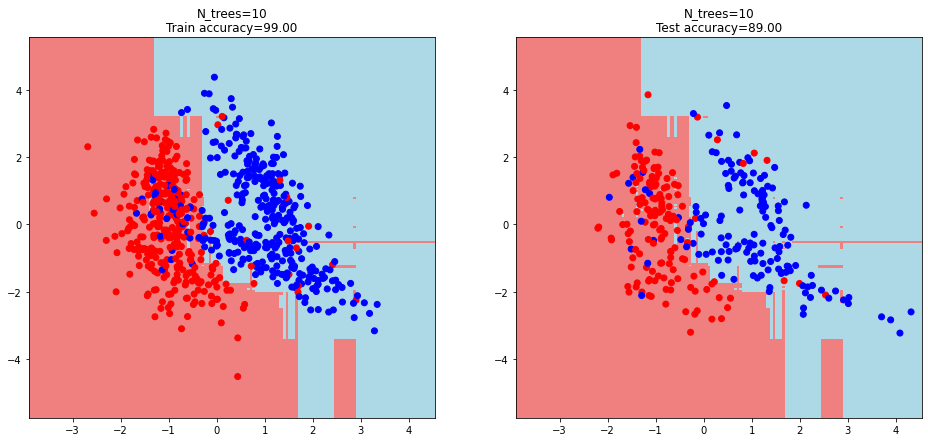

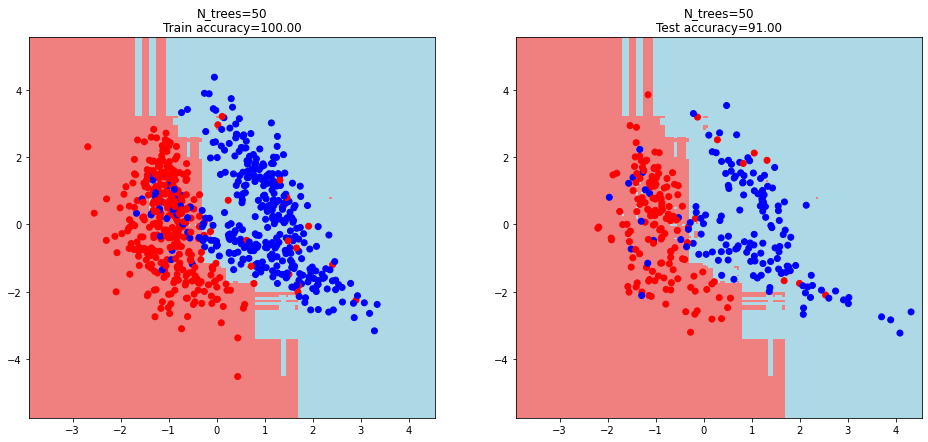

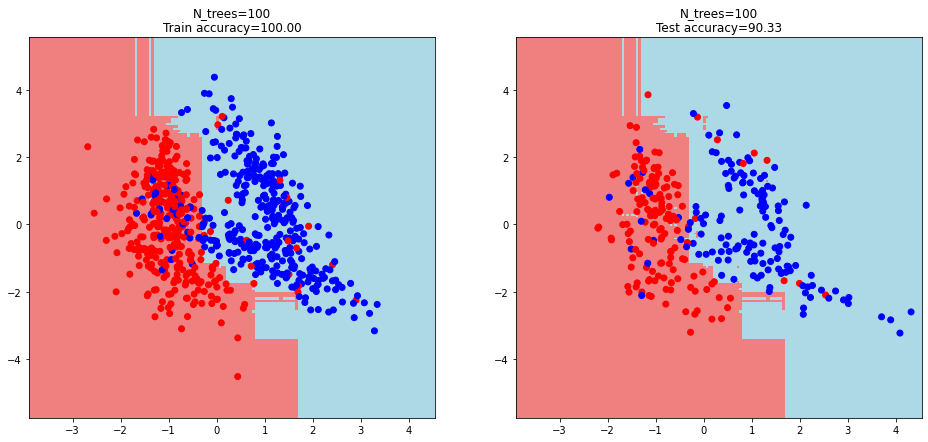

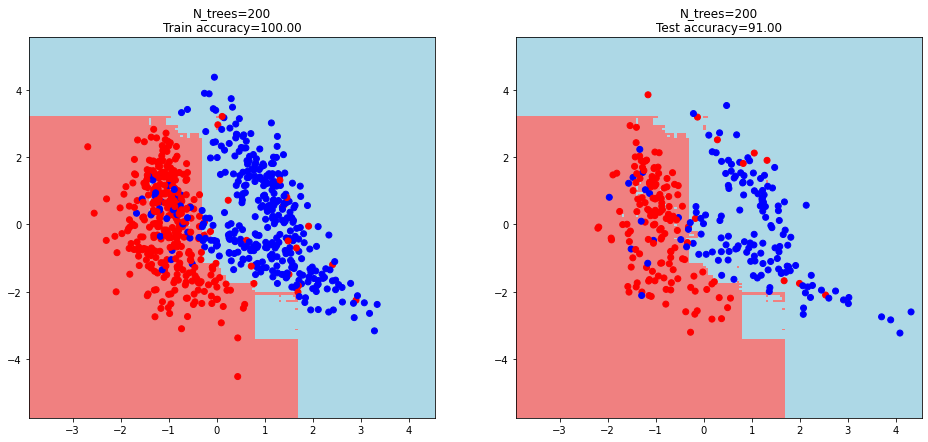

In [21]:
%%time
n_trees = [1, 3, 5, 10, 50, 100, 200]
for i in n_trees:
  my_forest = random_forest(train_data, train_labels, i)
  train_answers = tree_vote(my_forest, train_data)
  test_answers = tree_vote(my_forest, test_data)
  train_accuracy = accuracy_metric(train_labels, train_answers)
  test_accuracy = accuracy_metric(test_labels, test_answers)
  visualize(train_data, test_data) 
  print(f'Точность случайного леса из {i} деревьев на обучающей выборке: {train_accuracy:.3f}, на тестовой выборке: {test_accuracy:.3f}')
  

###Из данных видно, что с увеличением числа деревьев модель не переобучается, разделяющая гиперплоскость практически избавилась от длинных тонких линий, которые указывают на то, что модель пытается подстроиться под данные.